In [1]:
import os
import re
import json
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [2]:
def import_data():
    with open("data/automated/automatedAccountData.json") as json_file:
        automated_account_data = json.load(json_file)
    with open("data/automated/nonautomatedAccountData.json") as json_file:
        nonautomated_account_data = json.load(json_file)
        
    automated_account_dataframe = create_dataframe(automated_account_data)
    nonautomated_account_dataframe = create_dataframe(nonautomated_account_data)
    merged_dataframe = automated_account_dataframe.append(nonautomated_account_dataframe, ignore_index=True)
            
    return merged_dataframe

In [3]:
def create_dataframe(account_data_list):
    dataframe = pd.DataFrame({})

    for account_data in account_data_list:
        user_follower_count = account_data["userFollowerCount"]
        user_following_count = account_data["userFollowingCount"]
        follower_following_ratio = user_follower_count/max(1,user_following_count)
        
        temp_dataframe = pd.Series({"user_media_count":account_data["userMediaCount"],
                                    "user_follower_count":account_data["userFollowerCount"],
                                    "user_following_count":account_data["userFollowingCount"],
                                    "user_has_highligh_reels":account_data["userHasHighlighReels"],
                                    "user_has_external_url":account_data["userHasExternalUrl"],
                                    "user_tags_count":account_data["userTagsCount"],
                                    "follower_following_ratio":follower_following_ratio,
                                    "user_biography_length":account_data["userBiographyLength"],
                                    "username_length":account_data["usernameLength"],
                                    "username_digit_count":account_data["usernameDigitCount"],
                                    "media_comment_numbers":account_data["mediaCommentNumbers"],
                                    "media_comments_are_disabled":account_data["mediaCommentNumbers"],
                                    "media_has_location_info":account_data["mediaHasLocationInfo"],
                                    "media_hashtag_numbers":account_data["mediaHashtagNumbers"],
                                    "media_like_numbers":account_data["mediaLikeNumbers"],
                                    "mediaUpload_times":account_data["mediaUploadTimes"],
                                    "automated_behaviour":account_data["automatedBehaviour"]
                                    })
        dataframe = dataframe.append(temp_dataframe, ignore_index=True)
        
    return dataframe

In [4]:
def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)
    train_scores = scores['train_score']
    val_scores = scores['test_score']
    
    train_mean = np.mean(train_scores)
    val_mean = np.mean(val_scores)
    
    return train_mean, val_mean
    
def print_grid_search_result(grid_search):   
    print(grid_search.best_params_)
    
    best_train = grid_search.cv_results_["mean_train_score"][grid_search.best_index_]
    print("best mean_train_score: {:.3f}".format(best_train))
        
    best_test = grid_search.cv_results_["mean_test_score"][grid_search.best_index_]
    print("best mean_test_score: {:.3f}".format(best_test))

def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    data = confusion_matrix(y_actual, y_pred)
    ax = sns.heatmap(data,
                     annot=True,
                     cbar=False,
                     fmt='d',
                     xticklabels = labels,
                     yticklabels = labels)
    ax.set_title(title)
    ax.set_xlabel("predicted values")
    ax.set_ylabel("actual values")


## Automated accounts

In [5]:
df_automated = import_data()

In [6]:
df_automated['avg_media_comment_numbers'] = pd.DataFrame(df_automated['media_comment_numbers'].values.tolist()).mean(1)
df_automated['avg_media_has_location_info'] = pd.DataFrame(df_automated['media_has_location_info'].values.tolist()).mean(1)
df_automated['avg_media_hashtag_numbers'] = pd.DataFrame(df_automated['media_hashtag_numbers'].values.tolist()).mean(1)
df_automated['avg_media_like_numbers'] = pd.DataFrame(df_automated['media_like_numbers'].values.tolist()).mean(1)
df_automated['avg_media_comment_numbers'] = pd.DataFrame(df_automated['avg_media_comment_numbers']).fillna(0)
df_automated['avg_media_has_location_info'] = pd.DataFrame(df_automated['avg_media_has_location_info']).fillna(0)
df_automated['avg_media_hashtag_numbers'] = pd.DataFrame(df_automated['avg_media_hashtag_numbers']).fillna(0)
df_automated['avg_media_like_numbers'] = pd.DataFrame(df_automated['avg_media_like_numbers']).fillna(0)

In [7]:
class_names = ['Echt account', 'Automated account']

### Splitsen van data

In [8]:
X= df_automated[['user_media_count', 'user_follower_count', 'user_following_count',
       'user_has_highligh_reels', 'user_has_external_url', 'user_tags_count',
       'follower_following_ratio', 'user_biography_length', 'username_length',
       'username_digit_count', 'avg_media_comment_numbers',
       'avg_media_has_location_info',
       'avg_media_hashtag_numbers', 'avg_media_like_numbers']].values.reshape(-1,14)
y= df_automated['automated_behaviour'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Vergelijken van modellen met cross-validation

In [9]:
model_list = [LogisticRegression(max_iter=600),
              SVC(), 
              GaussianNB(),
              RandomForestClassifier(random_state=55),
              GradientBoostingClassifier(random_state=56)]

train_scores = []
val_scores = []

for model in model_list:
    train, val = get_classifier_cv_score(model, X_train, y_train,'average_precision')
    train_scores.append(train)
    val_scores.append(val)
    
models_score = sorted(list(zip(val_scores, train_scores, model_list)), reverse=True)

print("-------------------------------------")
for val, train, model in models_score:
    print("Model: {} ".format(model.__class__.__name__))

    print("train_score: {:.3f}".format(train)) 

    print("validation_score: {:.3f}".format(val)) 

    print("-------------------------------------")

C:\Users\Eigenaar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Eigenaar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

-------------------------------------
Model: GradientBoostingClassifier 
train_score: 1.000
validation_score: 0.987
-------------------------------------
Model: RandomForestClassifier 
train_score: 1.000
validation_score: 0.985
-------------------------------------
Model: SVC 
train_score: 0.953
validation_score: 0.954
-------------------------------------
Model: LogisticRegression 
train_score: 0.958
validation_score: 0.945
-------------------------------------
Model: GaussianNB 
train_score: 0.949
validation_score: 0.939
-------------------------------------


### Hyperparameter tuning met grid search

In [10]:
model = RandomForestClassifier(random_state=55)

parameters = {'n_estimators': [300, 500, 700, 1000],
              'max_depth': [7, 9, 11, 13]}

grid1 = GridSearchCV(model, parameters, cv=7, scoring='average_precision',return_train_score=True)
grid1.fit(X_train, y_train)
print_grid_search_result(grid1)

{'max_depth': 9, 'n_estimators': 500}
best mean_train_score: 1.000
best mean_test_score: 0.988


### Grid search -> gradient boosting classifier

In [11]:
model = GradientBoostingClassifier(max_depth=5, random_state=56)

parameters = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0]}

grid2 = GridSearchCV(model, parameters, cv=7, scoring='average_precision', return_train_score=True)
grid2.fit(X_train, y_train)
print_grid_search_result(grid2)

{'learning_rate': 0.1, 'n_estimators': 100}
best mean_train_score: 1.000
best mean_test_score: 0.986


### Pipeline

In [12]:
pipeline = Pipeline([('preprocessing', StandardScaler()), ('classifier', grid1.best_estimator_)])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=9, n_estimators=500,
                                        random_state=55))])

### Final evaluation

In [13]:
print("Test score: {:.3f}".format(pipeline.score(X_test, y_test)))

Test score: 0.961


In [14]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

     Echt account       0.96      0.96      0.96       135
Automated account       0.96      0.97      0.96       145

         accuracy                           0.96       280
        macro avg       0.96      0.96      0.96       280
     weighted avg       0.96      0.96      0.96       280



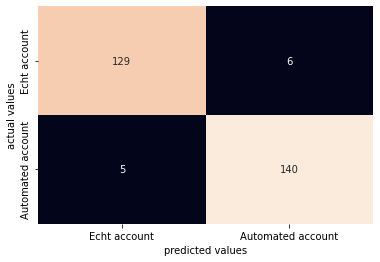

In [15]:
plot_confusion_matrix(y_test, y_pred, class_names)

In [16]:
# test mijn mijn instagram account
X_britt = [[3, 621, 428, 0, 0, 1, (621/428), 1, 13, 0, 4, 0, 0, 118]]
y_pred = pipeline.predict(X_britt)
print(class_names[np.argmax(y_pred)])

Echt account
